### Data preprocessing of LinkedIn Job Postings Dataset
#### Setup and Library Installation

In [ ]:
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install scipy
# %pip install sklearn
# %pip install imbalanced-learn 

#### Library Imports



In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

#### Loading Data

In [3]:
# Load datasets from the CSV files for analysis.
job_postings = pd.read_csv('data/job_postings.csv')
job_skills = pd.read_csv('data/job_details/job_skills.csv')

companies = pd.read_csv('data/company_details/companies.csv')
mapping_skills = pd.read_csv('data/maps/skills.csv')

#### Dataset summary

In [4]:
unique_values = {
    'job_postings': job_postings['job_id'].nunique(), # details of job postings
    'job_skills': job_skills['job_id'].nunique(), # job posting with the required skill abbreviated
    'companies': companies['company_id'].nunique(), # information on the company
    'skills': mapping_skills['skill_name'].nunique() # maps between skill abbreviations and full skill names
    }
unique_values

{'job_postings': 33246, 'job_skills': 32422, 'companies': 11361, 'skills': 35}

#### Handling the integration of job_skills with mapping_skills
Merging job_skills with mapping_skills

In [5]:
# Merging job_skills with mapping_skills to replace skill_abr with skill_name
merged_skills = pd.merge(job_skills, mapping_skills, on='skill_abr', how='left')
merged_skills = merged_skills.drop('skill_abr', axis=1)
merged_skills.head()

,job_id,skill_name
0,3690843087,Accounting/Auditing
1,3690843087,Finance
2,3691763971,Management
3,3691763971,Manufacturing
4,3691775263,Management


In [6]:
merged_skills.shape

(56591, 2)

Aggregating Skills by Job ID

In [7]:
# Aggregation process is done to handle duplicate 'job_id's resulting from multiple skills per job:

# Grouping by 'job_id' and concatenating 'skill_name' values
grouped_skills = merged_skills.groupby('job_id')['skill_name'].agg(lambda x: ', '.join(x)).reset_index()

# Display the resulting DataFrame with unique 'job_id' rows and concatenated skills
print(grouped_skills)

           job_id                                    skill_name
0         3958427  Design, Art/Creative, Information Technology
1        85008768                   Sales, Business Development
2       102339515                   Business Development, Sales
3       108965123                                Administrative
4       133114754                   Sales, Business Development
...           ...                                           ...
32417  3757937095                        Information Technology
32418  3757938018                     Management, Manufacturing
32419  3757938019                                   Engineering
32420  3757940025                     Management, Manufacturing
32421  3757940104                                         Other

[32422 rows x 2 columns]


#### Handling the integration of job_postings with grouped_skills
Checking for missing data in Company ID's

In [8]:
missing_id = job_postings['company_id'].isnull().sum()
missing_id

654

Dropping rows with empty company_id's

In [9]:
# Shape of dataset before removing missing values
job_postings.shape

(33246, 28)

In [10]:
# Inplace = True operation will modify the DataFrame job_postings in place, and the changes will be applied directly to it 
# without the need to reassign the result to a new variable.
job_postings.dropna(subset=['company_id'], inplace=True)
job_postings.shape

(32592, 28)

In [11]:
missing_id = job_postings['company_id'].isnull().sum()
missing_id

0

Merging job_postings with grouped_skills

In [12]:
merged_job_postings_skills = pd.merge(job_postings, grouped_skills, on='job_id', how='left')

Converting company data type to int from float

In [13]:
# Because there used to be missing values in company id's, NaN was considered as float value, therefore all data in the column was converted
# to float from int
if 'company_id' in merged_job_postings_skills.columns:
    merged_job_postings_skills['company_id'] = merged_job_postings_skills['company_id'].astype('Int64')

In [14]:
merged_job_postings_skills.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420,"Management, Manufacturing"
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,NaN,Bachelor's Degree in Mechanical Engineering pr...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644,Engineering
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,Entry level,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,"Management, Manufacturing"
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,Mid-Senior level,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology


Reducing dimensionality of merged_job_postings_skills by dropping unnecessary columns

In [15]:
columns_to_drop = ['description', 'max_salary','med_salary','min_salary',
                   'pay_period', 'applies', 'formatted_work_type', 'remote_allowed',
                   'job_posting_url','views','title','application_url','application_type',
                   'expiry','skills_desc','posting_domain','sponsored','original_listed_time',
                   'work_type','currency','compensation_type','scraped','closed_time','listed_time'
                   ]
merged_job_postings_skills= merged_job_postings_skills.drop(columns=columns_to_drop,axis=1)
merged_job_postings_skills.head()


,job_id,company_id,location,formatted_experience_level,skill_name
0,3757940104,553718,"Little River, SC",Entry level,Other
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing"
2,3757938019,474443,"Bessemer, AL",NaN,Engineering
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing"
4,3757937095,437225,United States,Mid-Senior level,Information Technology


#### Handling the integration of merged_job_postings_skills with companies
Merging merged_job_postings_skills with companies


In [16]:
merged_data= pd.merge(merged_job_postings_skills, companies, on='company_id', how='left')
merged_data.head()

,job_id,company_id,location,formatted_experience_level,skill_name,name,description,company_size,state,country,city,zip_code,address,url
0,3757940104,553718,"Little River, SC",Entry level,Other,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing","Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...
2,3757938019,474443,"Bessemer, AL",NaN,Engineering,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing",Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...
4,3757937095,437225,United States,Mid-Senior level,Information Technology,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb


Reducing dimensionality by dropping unnecessary columns

In [17]:
columns_to_drop = ['description','company_size','zip_code','url','address','state','city']
merged_data= merged_data.drop(columns=columns_to_drop,axis=1)
merged_data.head()

,job_id,company_id,location,formatted_experience_level,skill_name,name,country
0,3757940104,553718,"Little River, SC",Entry level,Other,HearingLife,US
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing","Metalcraft of Mayville, Inc.",US
2,3757938019,474443,"Bessemer, AL",NaN,Engineering,"U.S. Tsubaki Power Transmission, LLC",US
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing",Episcopal Communities & Services,US
4,3757937095,437225,United States,Mid-Senior level,Information Technology,"iHerb, LLC",US


Displaying data in a better order

In [18]:
column_order = ['job_id','company_id','name','location','country','skill_name','formatted_experience_level']
merged_data = merged_data[column_order]
merged_data.head()

,job_id,company_id,name,location,country,skill_name,formatted_experience_level
0,3757940104,553718,HearingLife,"Little River, SC",US,Other,Entry level
1,3757940025,2192142,"Metalcraft of Mayville, Inc.","Beaver Dam, WI",US,"Management, Manufacturing",NaN
2,3757938019,474443,"U.S. Tsubaki Power Transmission, LLC","Bessemer, AL",US,Engineering,NaN
3,3757938018,18213359,Episcopal Communities & Services,"Aliso Viejo, CA",US,"Management, Manufacturing",Entry level
4,3757937095,437225,"iHerb, LLC",United States,US,Information Technology,Mid-Senior level


#### Identify remaining missing data in the merged dataset
Display columns with significant missing data

In [19]:
missing_data = merged_data.isnull().sum()
significant_missing_columns = missing_data[missing_data > 0].sort_values(ascending=True)
significant_missing_columns

country                         47
name                            51
skill_name                    1023
formatted_experience_level    8622
dtype: int64

Handling missing values of 'name' column

In [20]:
# After merging, 51 rows of company references in job_postings were non existent in the company id's dataset. 
missing_names = merged_data['name'].isnull().sum()

null_name_indices = merged_data[merged_data['name'].isnull()]['company_id']
print("Number of missing ID's:", missing_names)
print(null_name_indices)

Number of missing ID's: 51
7305     76999667
15698     3641332
15706     3641332
15968     3641332
16405     3641332
20379      165957
20382     2313067
20384     3079381
20385      272676
20387    64734122
20389    27116461
20391     4316275
20392     1124883
20393    19115854
20394     1485063
25366        2815
25369     3514329
25380     9215353
25381    26489605
25382    79378951
25388    34771768
32290    91187899
32294     9516195
32296    89908682
32297    18872958
32298       35602
32300    18630069
32302        3657
32304    14615655
32305       88684
32306    10563070
32307      371180
32308     2902815
32309    90633414
32310    20338460
32311     2899710
32312      145145
32314       90844
32315     1434753
32316     7573454
32317     4781041
32318      718651
32319    86746333
32320    82296828
32321    82684341
32322    96649998
32323     2641066
32355     6049228
32525    10033339
32536    81149246
32580    16265700
Name: company_id, dtype: Int64


In [21]:
merged_data.to_csv('data_preprocessed/merged_data.csv', index=False)

Dropping columns where name is null

In [22]:
# 'name' of companies that did not exist in companies.csv, but did in job_postings.csv, are null
merged_data.dropna(subset=['name'], inplace=True)

Handling missing values of 'skill_name' column

In [23]:
# Handling missing values of 'skill_name' column
col_skill_fill_other = ['skill_name']
for col in col_skill_fill_other:
    merged_data[col].fillna("Other", inplace=True)

Handling missing values of 'formatted_experience_level' column

In [24]:
# Categorical columns with missing values are filled with "Not Specified"
col_experience_fill_not_specified = ['formatted_experience_level']
for col in col_experience_fill_not_specified:
    merged_data[col].fillna("Not Specified", inplace=True)


Check for remaining missing values

In [25]:
remaining_missing = merged_data.isnull().sum()
remaining_missing_cols = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
remaining_missing_cols

Series([], dtype: int64)

#### Categorizing experience level

In [26]:
# Data Transformation
experience_levels = merged_data['formatted_experience_level'].unique()

for value in experience_levels:
    print(value)


Entry level
Not Specified
Mid-Senior level
Director
Associate
Executive
Internship


Mapping experience to their numeric new values

In [27]:
experience_mapping = {
    'Internship': 1,
    'Entry level': 2,
    'Associate':3, 
    'Mid-Senior level': 4,
    'Director': 5,
    'Executive': 6,
    'Not Specified': 7
}

merged_data['formatted_experience_level'] = merged_data['formatted_experience_level'].map(experience_mapping)

#### Cleaning data in 'name' attribute

In [28]:
def clean_company_names(name):

    # Remove special characters, except spaces and dots
    name = re.sub(r'[^a-zA-Z0-9\w\s\.]', '', name)

    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()

    # Handle hyphens and apostrophes
    name = name.replace('-', ' ')  # Replace hyphens with spaces
    name = name.replace('\'', '')  # Remove apostrophes
    name = re.sub(r'\s+', ' ', name)

    return name

merged_data['name'] = merged_data['name'].apply(clean_company_names)

#### Extract City from 'location' attribute

In [29]:
def extract_city(location):
    words = location.split()
    if len(words) == 1:  # Check if the location has only one word
        return None
    parts = location.split(', ')
    if len(parts) > 1:  # Check if the format is City, State, 
        return parts[0]
    else:
        if "Metropolitan Area" in location:
            return location.split(" Metropolitan Area")[0]
        elif "Area" in location or "Greater" in location:
            return location
        else:
            return None

# Apply the function to the 'location' column
merged_data['location'] = merged_data['location'].apply(extract_city)
merged_data.shape

(32541, 7)

In [30]:
remaining_missing = merged_data['location'].isnull().sum()
remaining_missing

2366

In [31]:
merged_data = merged_data.dropna(subset=['location'])
merged_data.shape

(30175, 7)

#### Preprocessed Dataset

Shape of the cleaned data

In [32]:
merged_data_cleaned = merged_data
merged_data_cleaned.shape

(30175, 7)

Rename column names 

In [33]:

merged_data_cleaned = merged_data_cleaned.rename(columns={'name':'company','skill_name':'required_skill',
                                                           'formatted_experience_level':'experience_level'})

merged_data_cleaned = merged_data_cleaned.sort_values('job_id', ascending=False)



Display

In [34]:
merged_data_cleaned

,job_id,company_id,company,location,country,required_skill,experience_level
0,3757940104,553718,HearingLife,Little River,US,Other,2
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,US,"Management, Manufacturing",7
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,US,Engineering,7
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,US,"Management, Manufacturing",2
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,CA,"Management, Manufacturing",2
...,...,...,...,...,...,...,...
32587,381055942,96654609,First Baptist Church Forney,Forney,US,Other,7
32588,133196985,1089558,Employvision Inc.,New York,US,"Accounting/Auditing, Finance",7
32589,133114754,77766802,CargoLogin.,Santa Clarita,US,"Sales, Business Development",7
32590,102339515,52132271,DryerVentz DuctVentz,Greater Boston,US,"Business Development, Sales",7


Save the preprocessed dataset to data_preprocessed.csv

In [35]:
merged_data_cleaned.to_csv('data_preprocessed/job_postings.csv', index=False)

### Detecting Outliers

Checking for outliers in Experience Level

In [36]:
merged_data_cleaned['Z_Score'] = np.abs(stats.zscore(merged_data_cleaned['experience_level'], nan_policy='omit'))
threshold = 3
outliers_z = merged_data_cleaned[merged_data_cleaned['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
Empty DataFrame
Columns: [job_id, company_id, company, location, country, required_skill, experience_level, Z_Score]
Index: []


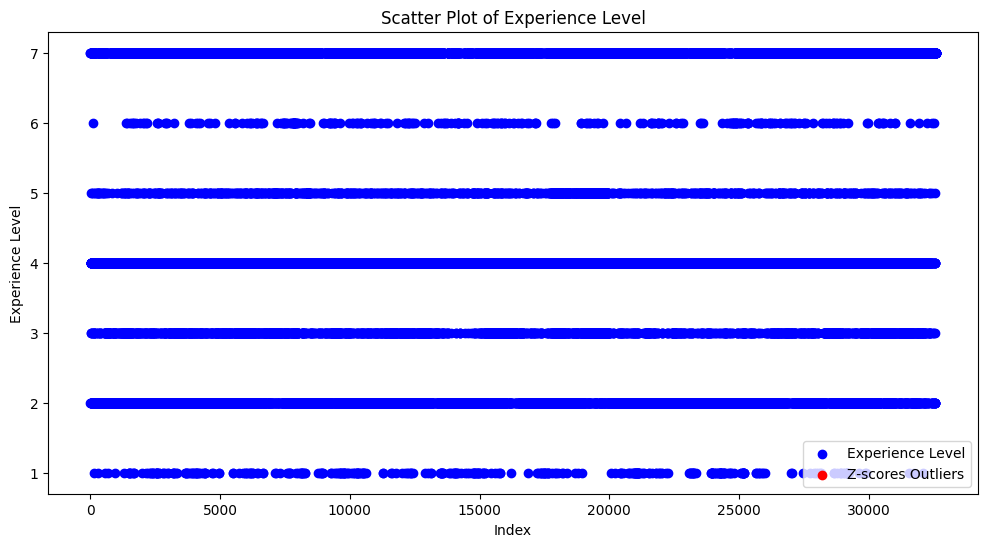

In [37]:
plt.figure(figsize=(12, 6))
plt.scatter(merged_data_cleaned.index, merged_data_cleaned['experience_level'], color='blue', label='Experience Level')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['experience_level'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot of Experience Level")
plt.xlabel("Index")
plt.ylabel("Experience Level")
plt.legend()
plt.show()

In [38]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans

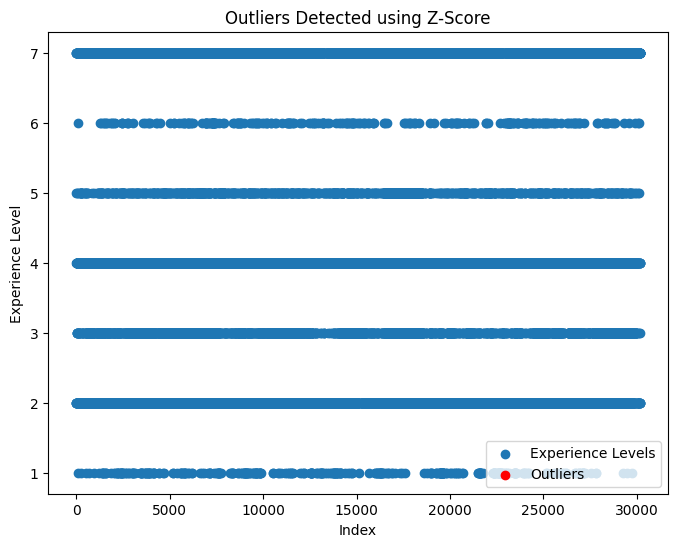

In [39]:
# Statistical Outlier Detection (using Z-Score)
def detect_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    return np.where(z_scores > threshold)

data = merged_data_cleaned['experience_level'].values
outliers_zscore = detect_outliers_zscore(data)

plt.figure(figsize=(8, 6))
plt.scatter(range(len(data)), data, label='Experience Levels')
plt.scatter(outliers_zscore, data[outliers_zscore], color='red', label='Outliers')
plt.title('Outliers Detected using Z-Score')
plt.xlabel('Index')
plt.ylabel('Experience Level')
plt.legend()
plt.show()

In [40]:
# Counting how many rows correspond to each unique value in a country column
value_counts = merged_data_cleaned['country'].value_counts()
print("Count of rows for each unique value:")
print(value_counts)

Count of rows for each unique value:
country
US    27484
GB      668
0       551
CA      347
IN      166
DE      158
CH      130
FR      120
IE       59
NL       54
DK       51
AU       48
SE       47
JP       40
OO       35
CN       23
IT       22
BE       19
ES       19
FI       14
SA       11
TW       10
KR        9
IL        9
NO        8
BM        8
AT        8
SG        7
AE        6
LI        5
LU        4
MX        4
HK        4
AZ        3
IS        3
NZ        2
PR        2
BR        2
ID        2
RU        1
EE        1
KE        1
MT        1
TR        1
GE        1
HU        1
UY        1
CO        1
CZ        1
AR        1
PH        1
MD        1
Name: count, dtype: int64


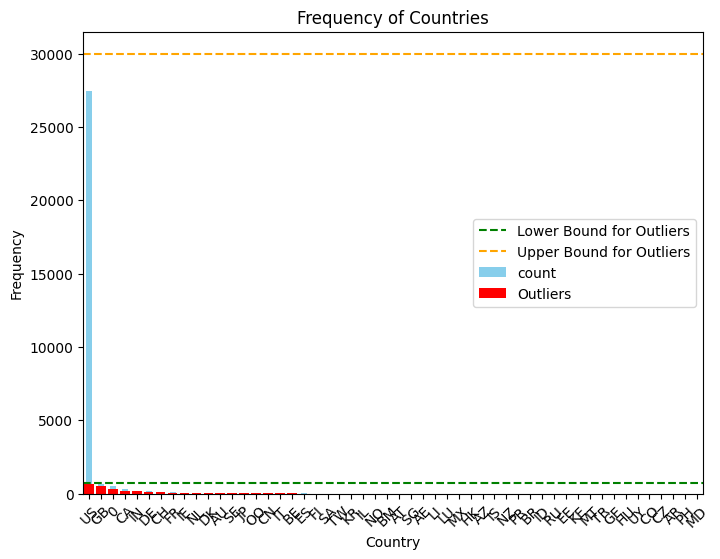

In [41]:
def detect_outliers_frequency(data, lower_bound=700, upper_bound=30000):
    value_counts = data.value_counts()
    outliers = value_counts[(value_counts < lower_bound) | (value_counts > upper_bound)].index.tolist()
    return outliers

country_data = merged_data_cleaned['country']

# Define the lower and upper bounds for outlier detection
lower_bound = 700   
upper_bound = 30000  

outliers_frequency = detect_outliers_frequency(country_data, lower_bound, upper_bound)

# Visualizing Frequency-Based Outliers
plt.figure(figsize=(8, 6))
country_counts = country_data.value_counts()
country_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Countries')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Highlighting outliers
plt.bar(outliers_frequency, country_counts[outliers_frequency], color='red', label='Outliers')

plt.axhline(y=lower_bound, color='green', linestyle='--', label='Lower Bound for Outliers')
plt.axhline(y=upper_bound, color='orange', linestyle='--', label='Upper Bound for Outliers')
plt.legend()
plt.show()

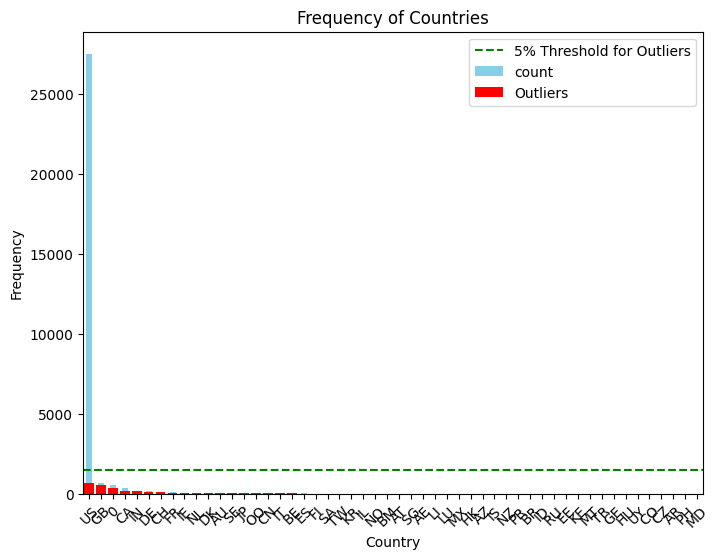

In [42]:
def detect_outliers_frequency(data, threshold_percentage=5):
    total_count = len(data)
    value_counts = data.value_counts()
    threshold_count = total_count * threshold_percentage / 100
    outliers = value_counts[value_counts < threshold_count].index.tolist()
    return outliers

country_data = merged_data_cleaned['country']
total_count = len(country_data)
# Detect outliers where occurrences are less than 5% of the total data
outliers_frequency = detect_outliers_frequency(country_data)

# Visualizing Frequency-Based Outliers
plt.figure(figsize=(8, 6))
country_counts = country_data.value_counts()
country_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Countries')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Highlighting outliers
plt.bar(outliers_frequency, country_counts[outliers_frequency], color='red', label='Outliers')

# Showing the 5% threshold line
plt.axhline(y=total_count * 0.05, color='green', linestyle='--', label='5% Threshold for Outliers')
plt.legend()
plt.show()

In [43]:
company_country = merged_data_cleaned['country'].unique()
company_country


array(['US', 'CA', 'FR', 'GB', '0', 'NL', 'DK', 'LI', 'JP', 'CH', 'BE',
       'SE', 'IN', 'AU', 'CN', 'DE', 'ES', 'KR', 'MT', 'IE', 'IL', 'OO',
       'IT', 'LU', 'EE', 'AT', 'BM', 'FI', 'ID', 'AE', 'AZ', 'IS', 'TW',
       'MX', 'SG', 'NO', 'HK', 'NZ', 'RU', 'BR', 'KE', 'SA', 'TR', 'GE',
       'HU', 'PR', 'UY', 'CO', 'CZ', 'AR', 'PH', 'MD'], dtype=object)

##### Detecting and removing anomalies

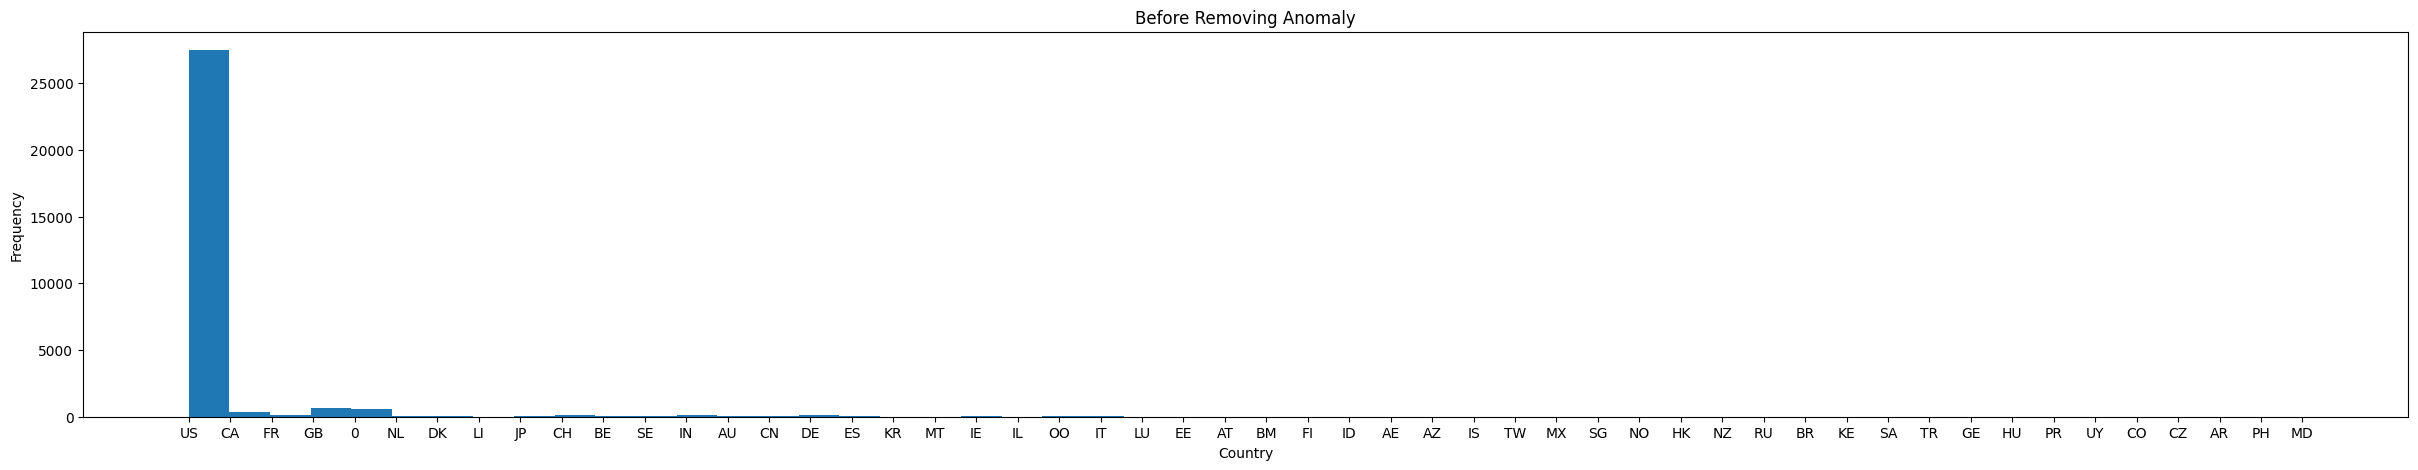

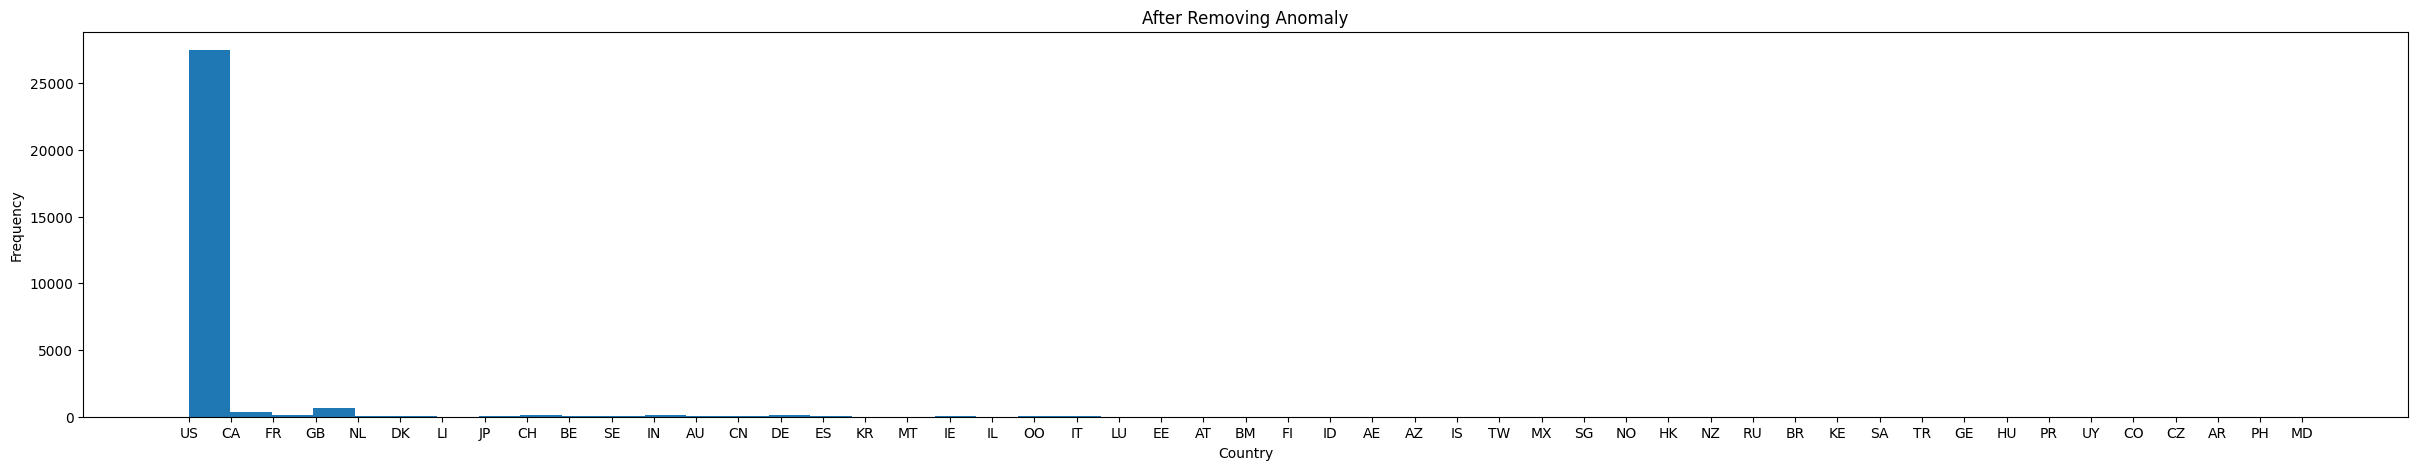

DataFrame after removing anomalies:
           job_id  company_id                              company  \
0      3757940104      553718                          HearingLife   
1      3757940025     2192142          Metalcraft of Mayville Inc.   
2      3757938019      474443  U.S. Tsubaki Power Transmission LLC   
3      3757938018    18213359       Episcopal Communities Services   
6      3757937004    10515052             Boyd Group Services Inc.   
...           ...         ...                                  ...   
32587   381055942    96654609          First Baptist Church Forney   
32588   133196985     1089558                    Employvision Inc.   
32589   133114754    77766802                          CargoLogin.   
32590   102339515    52132271                 DryerVentz DuctVentz   
32591     3958427      630152                    Karen Marie Salon   

             location country                                required_skill  \
0        Little River      US               

In [44]:
# Function to generate valid_countries dynamically based on length criteria
def generate_valid_countries(merged_data_cleaned):
    return list(merged_data_cleaned[merged_data_cleaned['country'].apply(len) == 2]['country'].unique())

# Generate valid_countries list dynamically
valid_countries = generate_valid_countries(merged_data_cleaned)

# Function to identify anomalies based on domain-specific knowledge
def remove_country_anomalies(merged_data_cleaned, valid_countries):
    return merged_data_cleaned[merged_data_cleaned['country'].isin(valid_countries)]

# Visualize data before removing anomalies
plt.figure(figsize=(30, 5))
plt.hist(merged_data_cleaned['country'], bins=len(merged_data_cleaned['country'].unique()))
plt.title('Before Removing Anomaly')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

# Detect and remove anomalies based on domain-specific knowledge
cleaned_df = remove_country_anomalies(merged_data_cleaned, valid_countries)

# Visualize data after removing anomalies
plt.figure(figsize=(30, 5))
plt.hist(cleaned_df['country'], bins=len(cleaned_df['country'].unique()))
plt.title('After Removing Anomaly')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

# Display the cleaned DataFrame
print("DataFrame after removing anomalies:")
print(cleaned_df)

In [45]:
count_anomalies = (cleaned_df['country'] == '0').sum()

print("Number of anomalies in the 'country' column:", count_anomalies)

Number of anomalies in the 'country' column: 0


In [46]:
cleaned_df = cleaned_df[cleaned_df['country'] != '0']

In [47]:
value_counts = cleaned_df['country'].value_counts()
print("Count of rows for each unique value:")
print(value_counts)

Count of rows for each unique value:
country
US    27484
GB      668
CA      347
IN      166
DE      158
CH      130
FR      120
IE       59
NL       54
DK       51
AU       48
SE       47
JP       40
OO       35
CN       23
IT       22
BE       19
ES       19
FI       14
SA       11
TW       10
KR        9
IL        9
NO        8
BM        8
AT        8
SG        7
AE        6
LI        5
LU        4
MX        4
HK        4
AZ        3
IS        3
NZ        2
PR        2
BR        2
ID        2
RU        1
EE        1
KE        1
MT        1
TR        1
GE        1
HU        1
UY        1
CO        1
CZ        1
AR        1
PH        1
MD        1
Name: count, dtype: int64


In [48]:
def generate_country_mapping(countries):
    country_mapping = {country: index + 1 for index, country in enumerate(countries)}
    return country_mapping

# Example input array
input_countries = cleaned_df['country'].unique()

# Generate the mapping using the function
country_mapping = generate_country_mapping(input_countries)

# Display the resulting mapping
print(country_mapping)

{'US': 1, 'CA': 2, 'FR': 3, 'GB': 4, 'NL': 5, 'DK': 6, 'LI': 7, 'JP': 8, 'CH': 9, 'BE': 10, 'SE': 11, 'IN': 12, 'AU': 13, 'CN': 14, 'DE': 15, 'ES': 16, 'KR': 17, 'MT': 18, 'IE': 19, 'IL': 20, 'OO': 21, 'IT': 22, 'LU': 23, 'EE': 24, 'AT': 25, 'BM': 26, 'FI': 27, 'ID': 28, 'AE': 29, 'AZ': 30, 'IS': 31, 'TW': 32, 'MX': 33, 'SG': 34, 'NO': 35, 'HK': 36, 'NZ': 37, 'RU': 38, 'BR': 39, 'KE': 40, 'SA': 41, 'TR': 42, 'GE': 43, 'HU': 44, 'PR': 45, 'UY': 46, 'CO': 47, 'CZ': 48, 'AR': 49, 'PH': 50, 'MD': 51}


In [49]:
cleaned_df['country'] = cleaned_df['country'].map(country_mapping)

In [50]:

merged_data_cleaned['country'] = cleaned_df['country'].astype(int)

Checking for Outliers in Country Column

In [51]:
cleaned_df['Z_Score'] = np.abs(stats.zscore(cleaned_df['country'], nan_policy='omit'))
threshold = 0.3
outliers_z = cleaned_df[cleaned_df['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
         job_id  company_id                      company    location  country  \
33   3757934281        2238                       Danone  Broomfield        3   
77   3757931732     6139709  Cambridgeshire Constabulary       House        4   
104  3757929899        2238                       Danone  Broomfield        3   
106  3757929719        2238                       Danone  Broomfield        3   
132  3757924360     1595517              Prospect Health    Oroville        4   

                                       required_skill  experience_level  \
33    Strategy/Planning, General Business, Management                 4   
77                                    Human Resources                 4   
104        Product Management, Management, Purchasing                 4   
106  Distribution, General Business, Public Relations                 4   
132                              Health Care Provider                 4   

      Z_Score  
33   0.

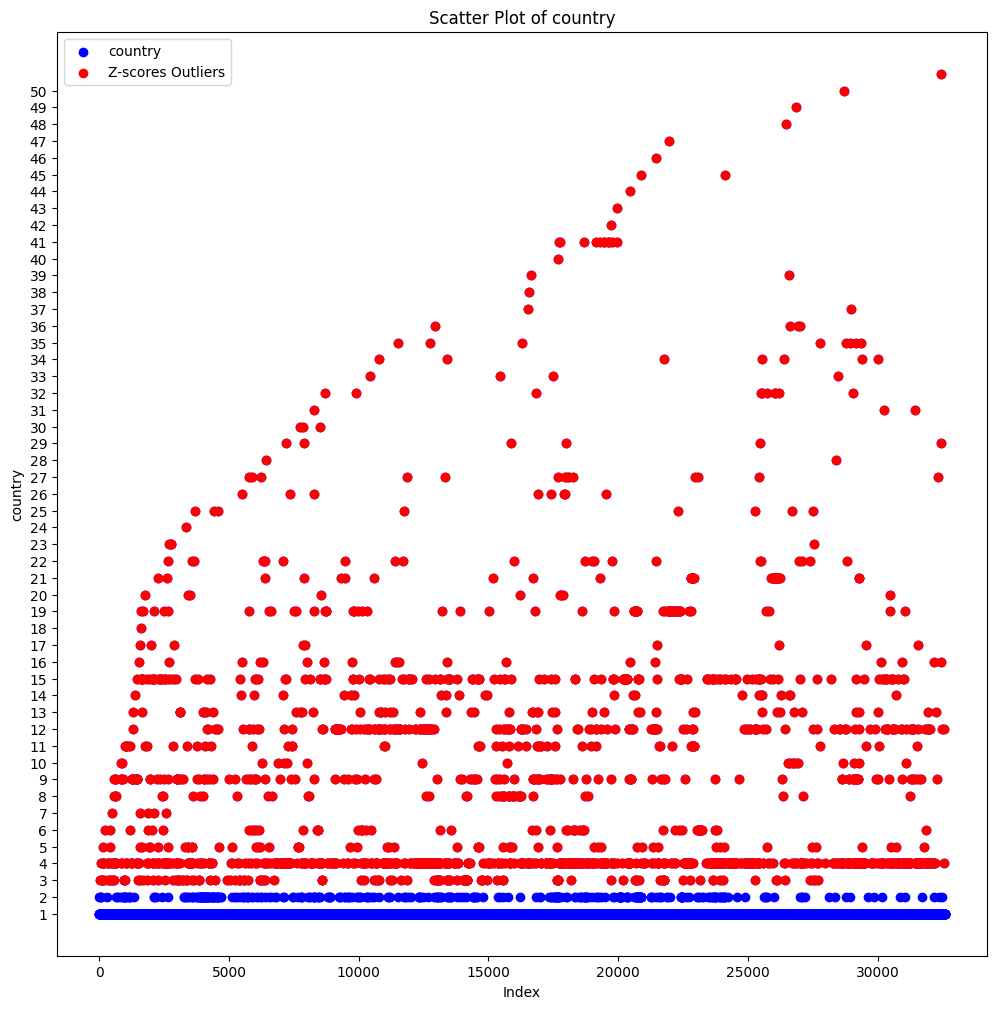

In [52]:
plt.figure(figsize=(12, 12))
plt.scatter(cleaned_df.index, cleaned_df['country'], color='blue', label='country')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['country'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot of country")
plt.xlabel("Index")
plt.ylabel("country")
plt.legend()

plt.yticks(range(1, 51))

plt.show()

In [53]:
country_counts = cleaned_df['country'].value_counts()

# Define the percentile threshold, e.g., 99th percentile
threshold_percentile = 99

# Calculate the threshold based on the percentile
threshold_value = country_counts.quantile(q=threshold_percentile / 100)

# Identify outliers based on the threshold
outliers_dist = country_counts[country_counts < threshold_value]


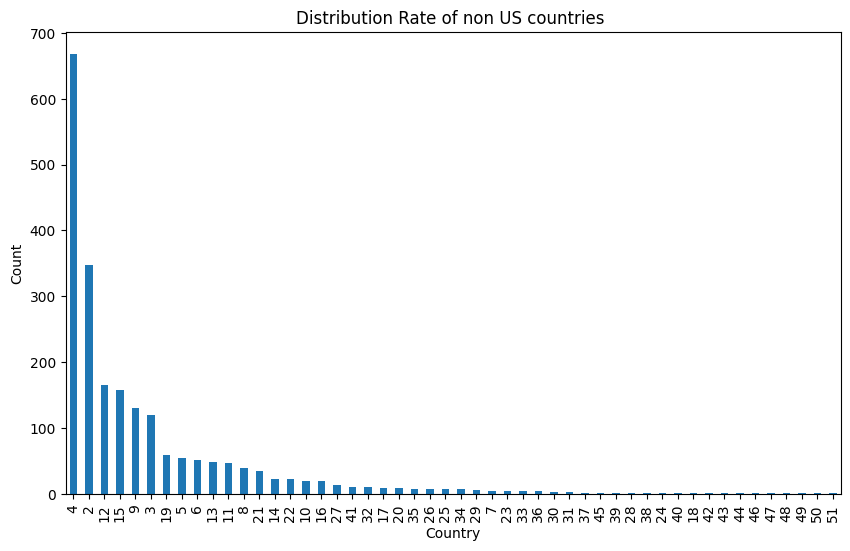

In [54]:
plt.figure(figsize=(10, 6))
outliers_dist.plot(kind='bar')
plt.title('Distribution Rate of non US countries ')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

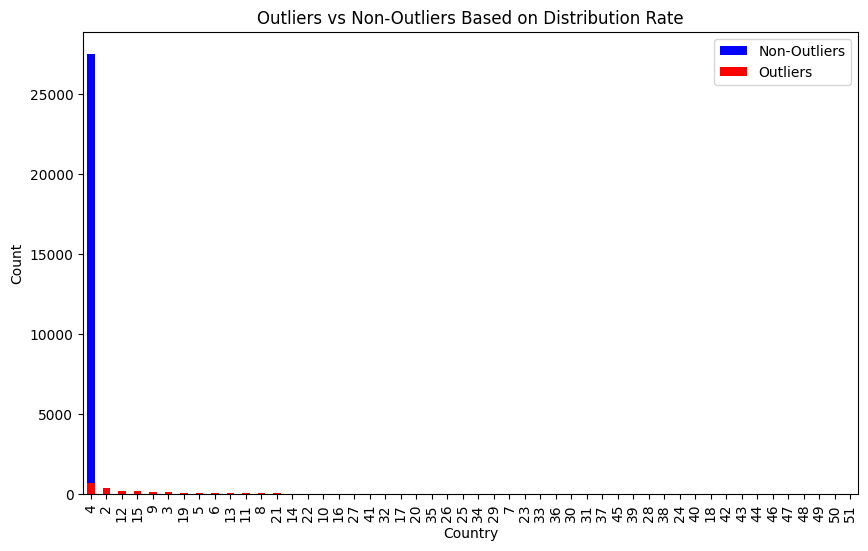

In [55]:
non_outliers = country_counts[country_counts >= threshold_value]

plt.figure(figsize=(10, 6))
non_outliers.plot(kind='bar', color='blue', label='Non-Outliers')
outliers_dist.plot(kind='bar', color='red', label='Outliers')
plt.title('Outliers vs Non-Outliers Based on Distribution Rate')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend()
plt.show()

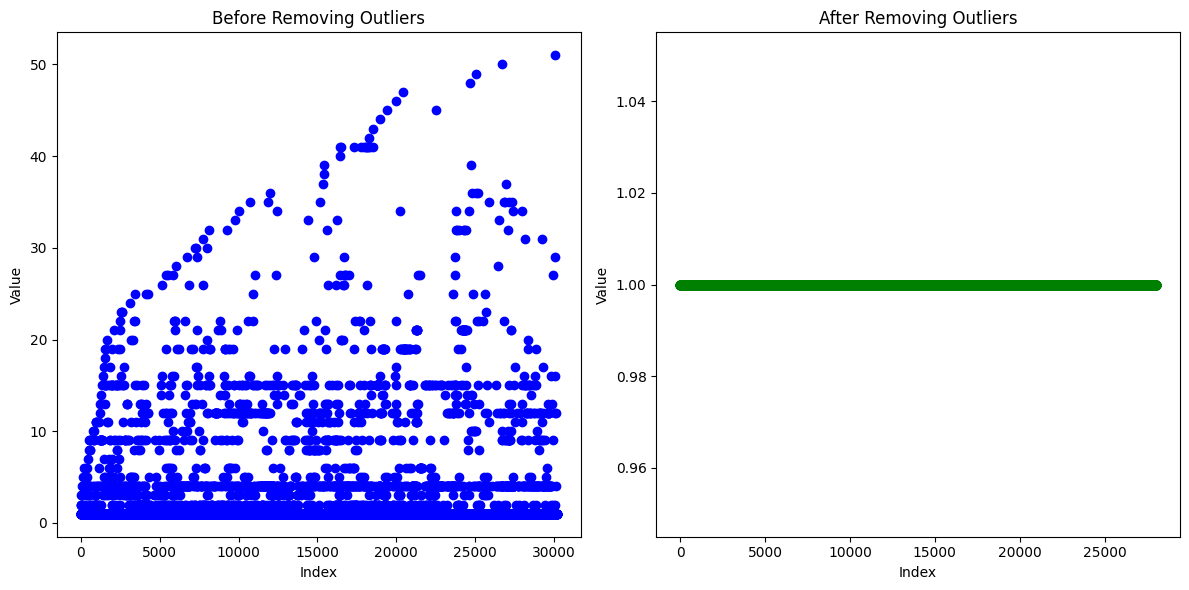

In [56]:
def detect_outliers_frequency(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

# Detect outliers
outliers = detect_outliers_frequency(merged_data_cleaned['country'])

# Create a scatter plot before removing outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(range(len(merged_data_cleaned)), merged_data_cleaned['country'], color='blue')
plt.title("Before Removing Outliers")
plt.xlabel("Index")
plt.ylabel("Value")

# Removing rows containing outliers
cleaned_data = merged_data_cleaned[~outliers]

# Create a scatter plot after removing outliers
plt.subplot(1, 2, 2)
plt.scatter(range(len(cleaned_data)), cleaned_data['country'], color='green')
plt.title("After Removing Outliers")
plt.xlabel("Index")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

### SMOTE Algorithm

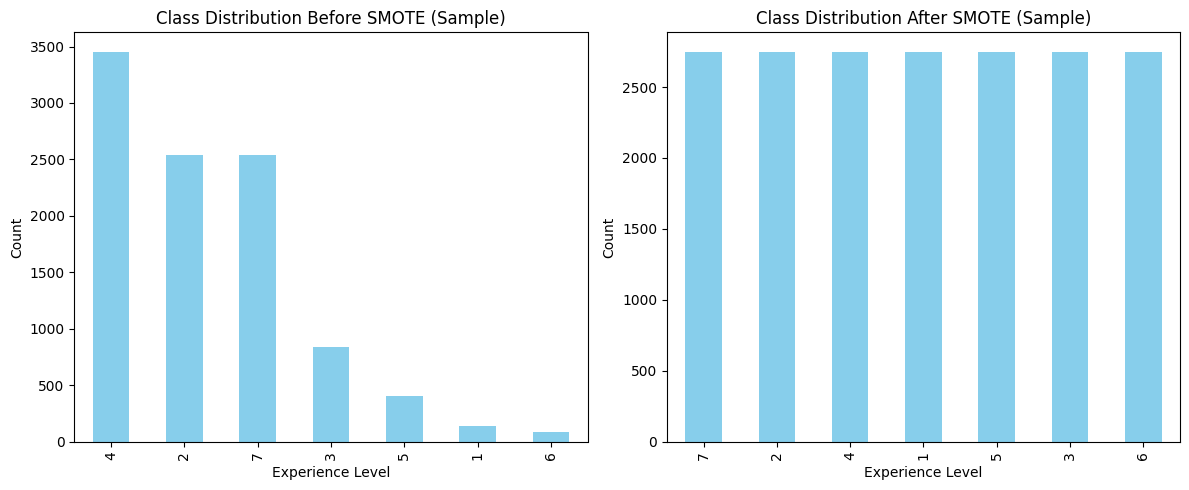

In [57]:
# Sample a subset of your data for faster visualization and testing
sample_size = 10000
df_sample = cleaned_df.sample(sample_size, random_state=42)

# Visualize class distribution before SMOTE for the sample
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_sample['experience_level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before SMOTE (Sample)')
plt.xlabel('Experience Level')
plt.ylabel('Count')

# Prepare data for modeling
X_sample = pd.get_dummies(df_sample.drop(['experience_level'], axis=1))
y_sample = df_sample['experience_level']

# Handle NaN values using simple imputation
imputer = SimpleImputer(strategy='mean')  # You can use other strategies as needed
X_sample_imputed = pd.DataFrame(imputer.fit_transform(X_sample), columns=X_sample.columns)

# Determine the appropriate number of neighbors
n_neighbors = min(5, X_sample_imputed.shape[0] - 1)  # Set an appropriate maximum value
if n_neighbors >= X_sample_imputed.shape[0]:
    n_neighbors = X_sample_imputed.shape[0] - 1

# Split the sample dataset into training and testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample_imputed, y_sample, test_size=0.2, random_state=42
)

# Apply SMOTE to balance the sample dataset
smote = SMOTE(random_state=42, k_neighbors=min(n_neighbors, X_train_sample.shape[0] - 1))
X_train_resampled_sample, y_train_resampled_sample = smote.fit_resample(
    X_train_sample, y_train_sample
)

# Visualize class distribution after SMOTE for the sample
plt.subplot(1, 2, 2)
pd.Series(y_train_resampled_sample).value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution After SMOTE (Sample)')
plt.xlabel('Experience Level')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [58]:
# Random sampling from the dataset
sample_size = 20  
sample = cleaned_df.sample(n=sample_size, random_state=42)  # Random state for reproducibility

# Display the sampled data
sample.head(100)

,job_id,company_id,company,location,country,required_skill,experience_level,Z_Score
814,3757776312,74985,Goodwin Recruiting,Castle Rock,1,Management,4,0.190150
9638,3756113467,2589107,Pioneer Healthcare Services,Roseville,1,Other,2,0.190150
21270,3699403927,164808,Madison Square Garden Entertainment Corp.,New York,1,Information Technology,7,0.190150
21482,3699092684,56833,SSi People,St Louis,1,"Engineering, Manufacturing",4,0.190150
27689,3693586843,123958,WT Offshore,Houston,1,Accounting/Auditing,4,0.190150
1757,3757739637,451202,Getinge,Wayne,11,Quality Assurance,4,3.262079
4673,3757489201,491462,LBS,Volusia County,1,"Project Management, Information Technology",2,0.190150
1845,3757738711,163139,Cogent Communications,Herndon,1,Information Technology,2,0.190150
5351,3757482756,88236,Amerit Consulting,Irving,1,Customer Service,4,0.190150
28080,3693583403,459969,PURIS,The Woodlands,1,"Finance, Sales",4,0.190150


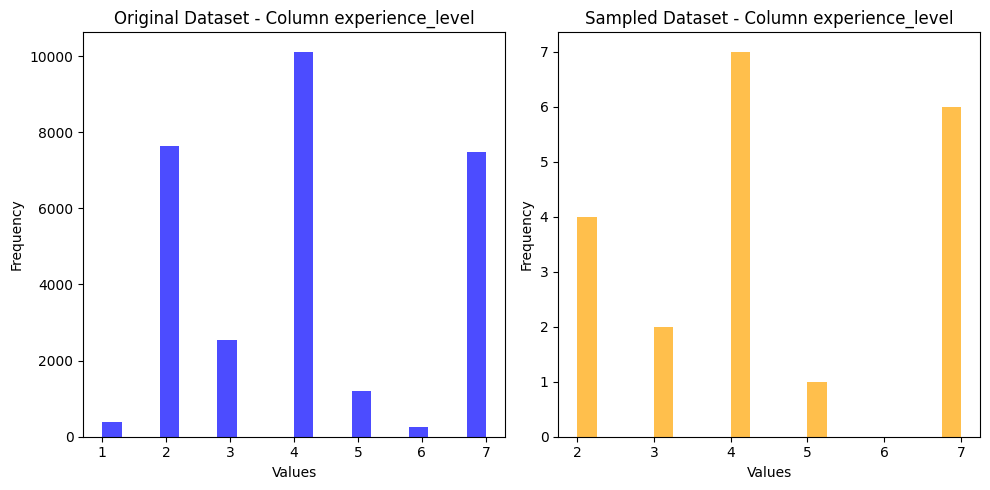

In [59]:
# Assuming 'A' column is one of the columns in your dataset
plt.figure(figsize=(10, 5))

# Original dataset histogram
plt.subplot(1, 2, 1)
plt.hist(cleaned_df['experience_level'], bins=20, color='blue', alpha=0.7)
plt.title('Original Dataset - Column experience_level')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Sampled dataset histogram
plt.subplot(1, 2, 2)
plt.hist(sample['experience_level'], bins=20, color='orange', alpha=0.7)
plt.title('Sampled Dataset - Column experience_level')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

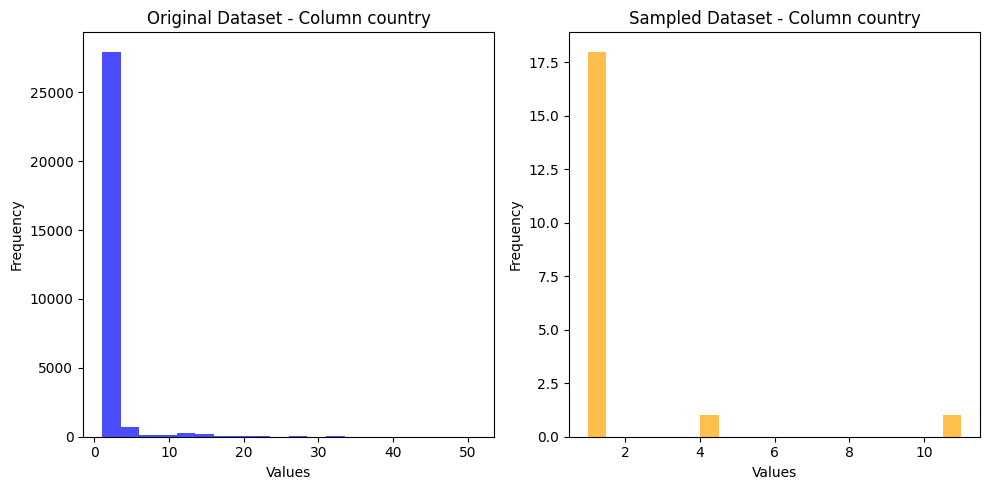

In [60]:
# Assuming 'A' column is one of the columns in your dataset
plt.figure(figsize=(10, 5))

# Original dataset histogram
plt.subplot(1, 2, 1)
plt.hist(cleaned_df['country'], bins=20, color='blue', alpha=0.7)
plt.title('Original Dataset - Column country')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Sampled dataset histogram
plt.subplot(1, 2, 2)
plt.hist(sample['country'], bins=20, color='orange', alpha=0.7)
plt.title('Sampled Dataset - Column country')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Skewness data

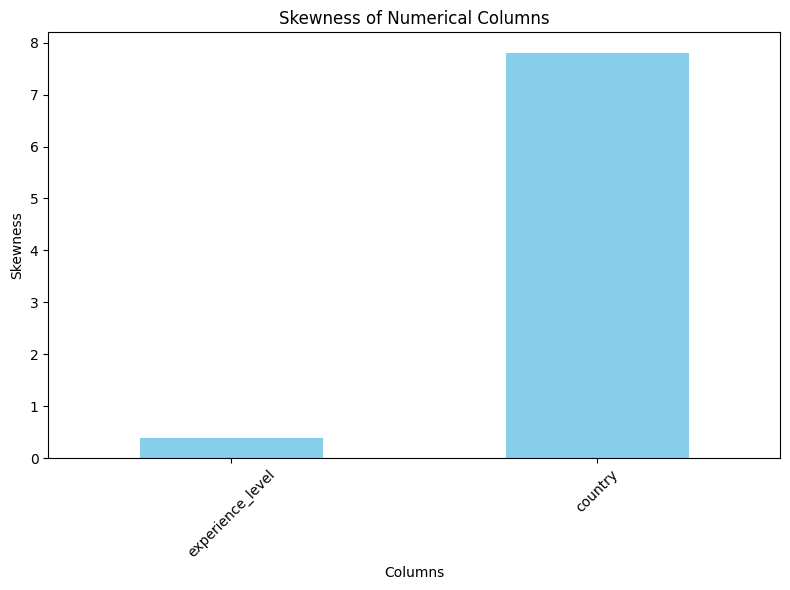

In [61]:
numerical_columns = ['experience_level', 'country']

# Calculating skewness for numerical columns
skewness_values = cleaned_df[numerical_columns].skew()

# Visualizing skewness
plt.figure(figsize=(8, 6))
skewness_values.plot(kind='bar', color='skyblue')
plt.title('Skewness of Numerical Columns')
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

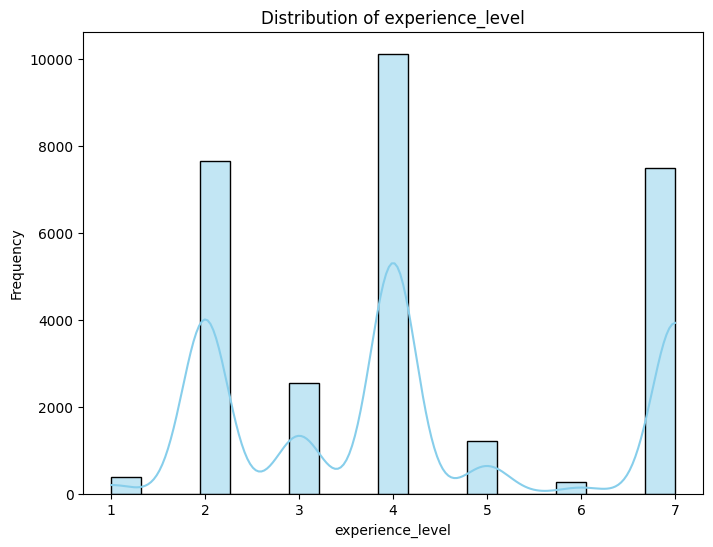

In [62]:
import seaborn as sns

# Selecting a single column for visualization
column_name = 'experience_level'

# Creating a distribution plot/histogram to visualize the skewness
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_df[column_name], kde=True, color='skyblue')
plt.title(f'Distribution of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()

In [66]:
cleaned_df.head()

,job_id,company_id,company,location,country,required_skill,experience_level,Z_Score
0,3757940104,553718,HearingLife,Little River,1,Other,2,0.190150
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,1,"Management, Manufacturing",7,0.190150
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,1,Engineering,7,0.190150
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,1,"Management, Manufacturing",2,0.190150
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,2,"Management, Manufacturing",2,0.155073


##### Separate the dataset into training and testing data

Training set shape - X: (23699, 7)  y: (23699,)
Testing set shape - X: (5925, 7)  y: (5925,)


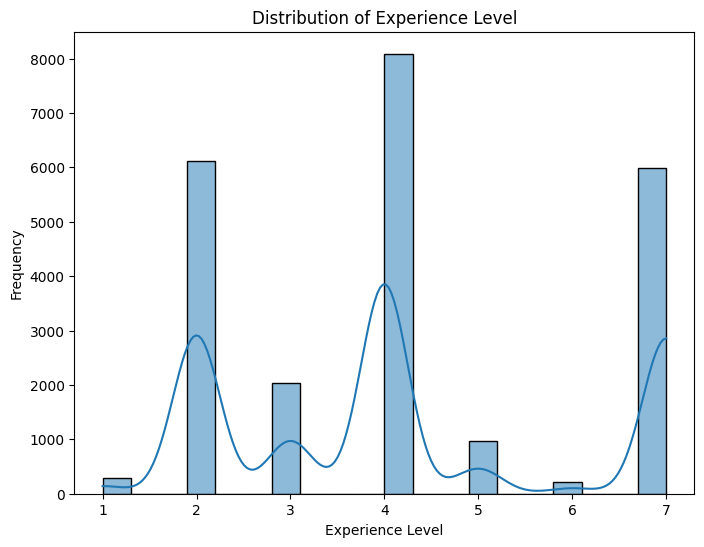

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'experience_level' is a numerical or categorical column

# Splitting the data into features (X) and target variable (y)
X = cleaned_df.drop('experience_level', axis=1)  # Features
y = cleaned_df['experience_level']  # Target variable

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets to verify the split
print("Training set shape - X:", X_train.shape, " y:", y_train.shape)
print("Testing set shape - X:", X_test.shape, " y:", y_test.shape)

# Visualizing the distribution of 'experience_level' in the training set
plt.figure(figsize=(8, 6))
sns.histplot(y_train, bins=20, kde=True)
plt.title('Distribution of Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Frequency')
plt.show()

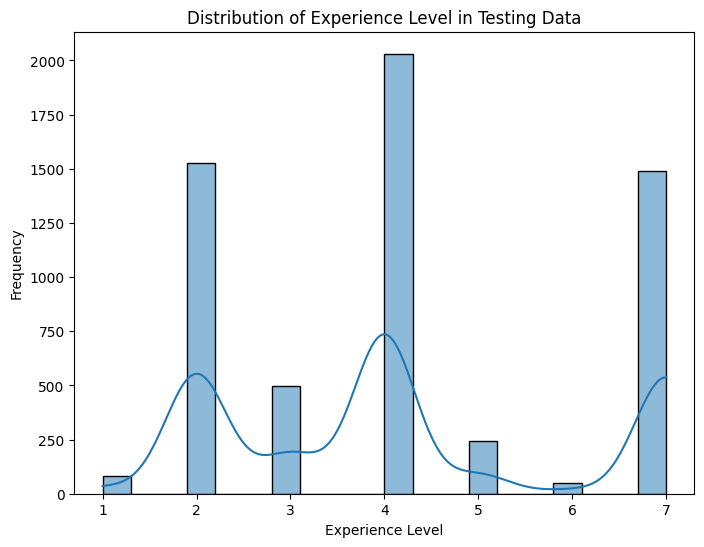

In [64]:
# Visualizing the distribution of 'experience_level' in the testing set
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=20, kde=True)
plt.title('Distribution of Experience Level in Testing Data')
plt.xlabel('Experience Level')
plt.ylabel('Frequency')
plt.show()

In [68]:
cleaned_df.head()

,job_id,company_id,company,location,country,required_skill,experience_level,Z_Score
0,3757940104,553718,HearingLife,Little River,1,Other,2,0.190150
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,1,"Management, Manufacturing",7,0.190150
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,1,Engineering,7,0.190150
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,1,"Management, Manufacturing",2,0.190150
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,2,"Management, Manufacturing",2,0.155073


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83


Training set shape - X: (23699, 7)  y: (23699,)
Testing set shape - X: (5925, 7)  y: (5925,)


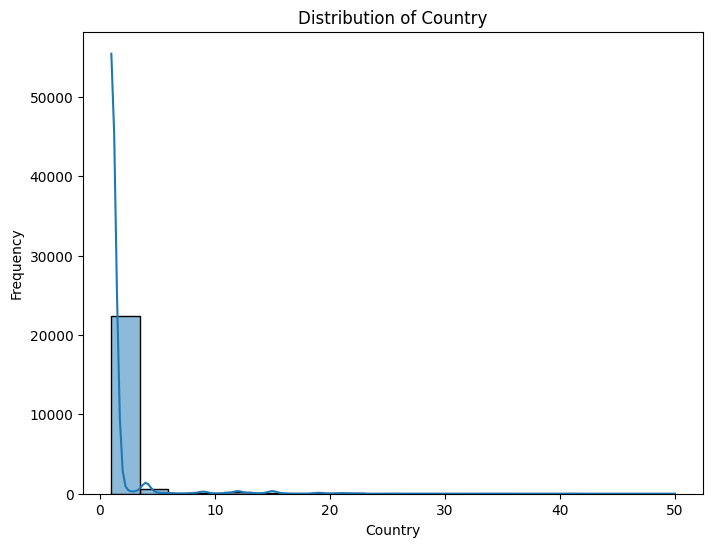

In [72]:
# Assuming 'experience_level' is a numerical or categorical column

# Splitting the data into features (X) and target variable (y)
X = cleaned_df.drop('country', axis=1)  # Features
y = cleaned_df['country']  # Target variable

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets to verify the split
print("Training set shape - X:", X_train.shape, " y:", y_train.shape)
print("Testing set shape - X:", X_test.shape, " y:", y_test.shape)

# Visualizing the distribution of 'experience_level' in the training set
plt.figure(figsize=(8, 6))
sns.histplot(y_train, bins=20, kde=True)
plt.title('Distribution of Country')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

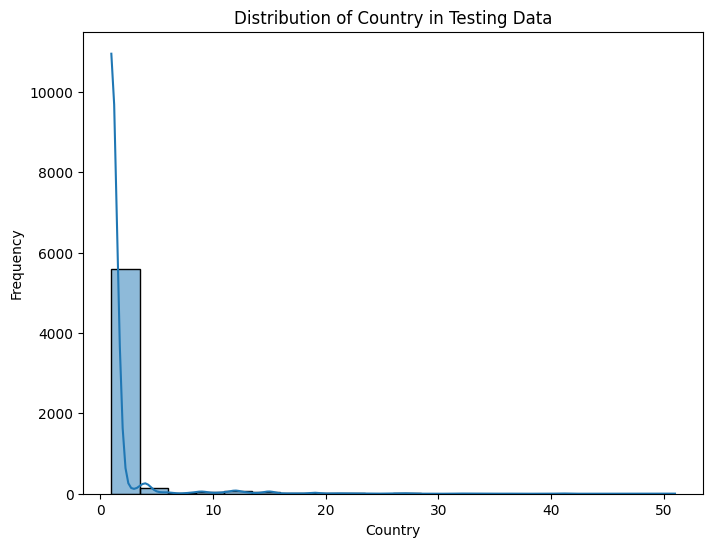

In [73]:
# Visualizing the distribution of 'experience_level' in the testing set
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=20, kde=True)
plt.title('Distribution of Country in Testing Data')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83


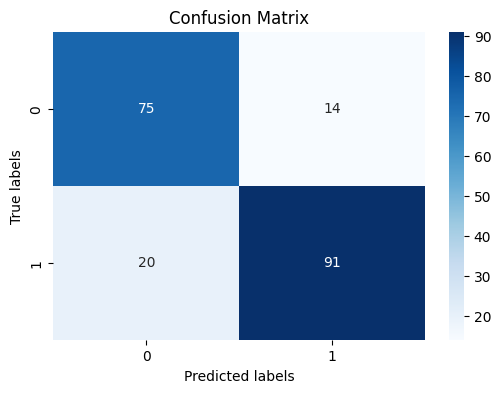

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##### Mean, Mode and Standard Deviation

In [77]:
# Calculate mean, mode, and standard deviation for numerical columns (e.g., 'country')
numerical_columns = ['experience_level','country']  

# Calculate mean
mean_values = cleaned_df[numerical_columns].mean()

# Calculate mode (for mode, multiple modes can exist)
mode_values = cleaned_df[numerical_columns].mode().iloc[0]  # Taking the first mode

# Calculate standard deviation
std_deviation_values = cleaned_df[numerical_columns].std()

median_values = cleaned_df[numerical_columns].median()

variance_values = cleaned_df[numerical_columns].var()


# Display the calculated statistics
print("Mean:")
print(mean_values)
print("\nMode:")
print(mode_values)
print("\nStandard Deviation:")
print(std_deviation_values)
print("\nMedian:")
print(median_values)
print("\nVariance:")
print(variance_values)


Mean:
experience_level    4.177390
country             1.550803
dtype: float64

Mode:
experience_level    4
country             1
Name: 0, dtype: int64

Standard Deviation:
experience_level    1.884137
country             2.896728
dtype: float64

Median:
experience_level    4.0
country             1.0
dtype: float64

Variance:
experience_level    3.549972
country             8.391032
dtype: float64


##### Histogram with Mean, Mode and Median

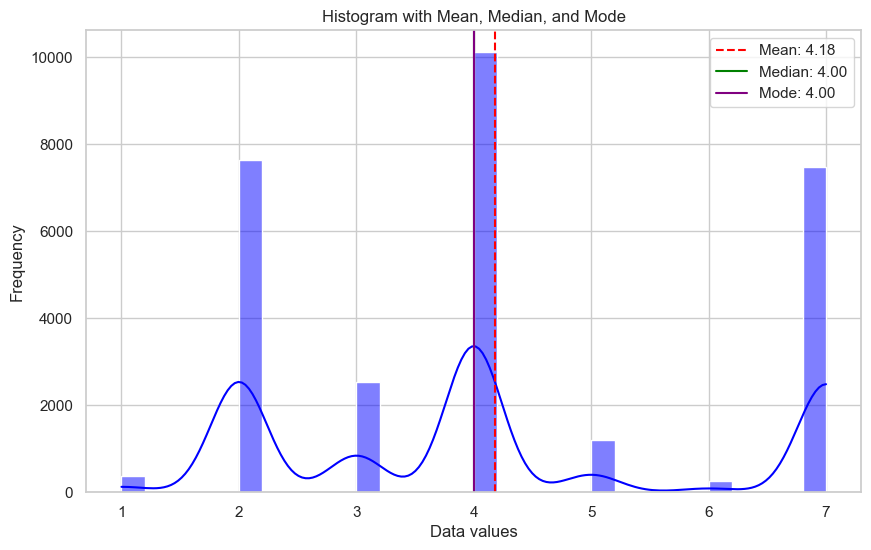

In [78]:
data = np.array(cleaned_df['experience_level'])

# Calculate mean and median
mean = np.mean(data)
median = np.median(data)

# Calculate mode and its count
mode_res = stats.mode(data)

# Extract the mode and count values
mode = mode_res.mode.item()  # Convert numpy scalar to a Python scalar
count = mode_res.count.item()

# Plot the distribution and mark the mean, median, and mode
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, color="blue", bins=30)
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.2f}')
plt.axvline(mode, color='purple', linestyle='-', label=f'Mode: {mode:.2f}')

plt.legend()
plt.title('Histogram with Mean, Median, and Mode')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.show()


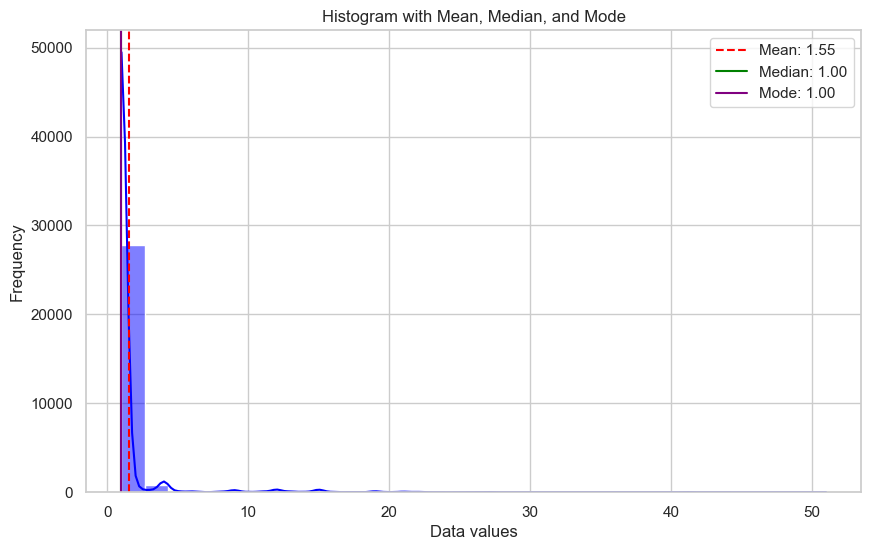

In [79]:
data = np.array(cleaned_df['country'])

# Calculate mean and median
mean = np.mean(data)
median = np.median(data)

# Calculate mode and its count
mode_res = stats.mode(data)

# Extract the mode and count values
mode = mode_res.mode.item()  # Convert numpy scalar to a Python scalar
count = mode_res.count.item()

# Plot the distribution and mark the mean, median, and mode
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, color="blue", bins=30)
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.2f}')
plt.axvline(mode, color='purple', linestyle='-', label=f'Mode: {mode:.2f}')

plt.legend()
plt.title('Histogram with Mean, Median, and Mode')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
cleaned_df.to_csv('data_preprocessed/final_data.csv', index=False)